### Working with Time Series

In [29]:
# Importing Libraries:

import pandas as pd
from matplotlib import pyplot as plt
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# Holt Winters 
# Single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# Double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math

# Warning suppression
import warnings
warnings.filterwarnings("ignore")

In [30]:
# Importing data

df = pd.read_csv('us_retail_sales.csv')

In [31]:
# Reformatting the data to work with 2 columns with date and sales values

# Melt
df = pd.melt(df, id_vars=['YEAR'], var_name=['Month']) 

# New Date Variable
df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + '-' + df['Month'].astype(str))   

# Sort by date and remove unneeded columns
df = df.sort_values(by=['Date']).drop(columns=['Month', 'YEAR']).reset_index(drop=['index']) 

In [32]:
# Confirm updated correctly
df.head()

,value,Date
0,146925.0,1992-01-01
1,147223.0,1992-02-01
2,146805.0,1992-03-01
3,148032.0,1992-04-01
4,149010.0,1992-05-01


Text(0, 0.5, 'Instances')

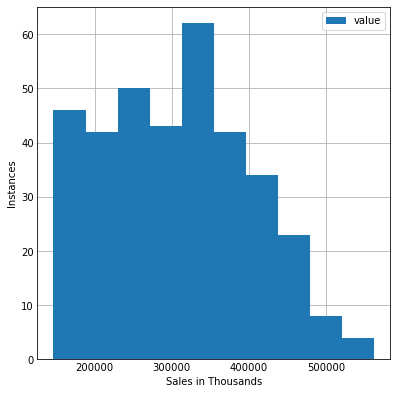

In [33]:
# Plotting the data w/ proper labeling and make some basic observations

df.plot(kind='hist')
plt.xlabel('Sales in Thousands')
plt.ylabel('Instances')

<AxesSubplot:title={'center':'Total Sales by Dollar Value over Time'}>

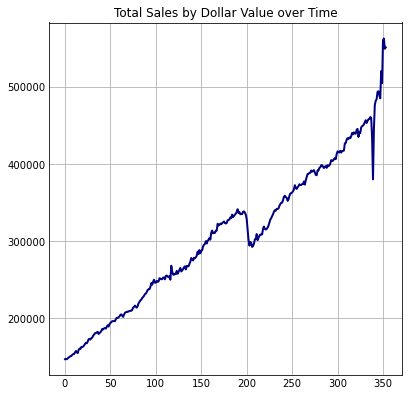

In [34]:
df['value'].plot(lw=2, colormap='jet', markersize=10, 
         title='Total Sales by Dollar Value over Time')

In [35]:
# Finding Nan values
df.isnull().values.any()

True

In [36]:
df['value'].isnull().sum()

6

In [37]:
# Remove Nan values
df.dropna(inplace=True)

In [38]:
# Finding new df dimensions
df.shape

(354, 2)

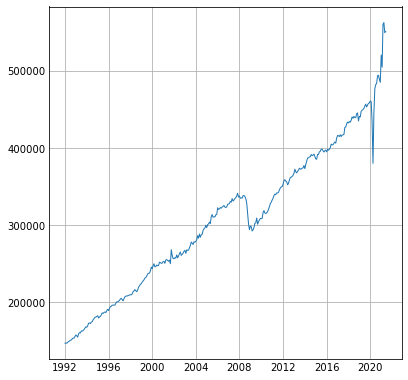

In [39]:
# Setting plot style
plt.style.use('_mpl-gallery')

# Make data
x = df['Date']
y = df['value']
plt.rcParams['figure.figsize'] = [5,5]
# Plot
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=1.0)

plt.show()


# This graph does not appear to show seasonality throughout each year as much as it does show
# economic factors like recessions (2008, 2020 as examples). However, that is not to say there
# is no seasonality, simply that the overall upward trend in sales is what stands out most

In [40]:
# The next couple of cells show a test I used that essentially helps confirm that there is
# an element of seasonality to the data. It is interesting because the graphs above do not 
# show this as detailed as the following visualizations will help support:

from statsmodels.tsa.stattools import adfuller
dftest = adfuller(df['value'], autolag='AIC')
dftest[1]

# The value close to 1 (0.997) indicates a high likelihood of seasonality in a numeric format

0.9973259755033455

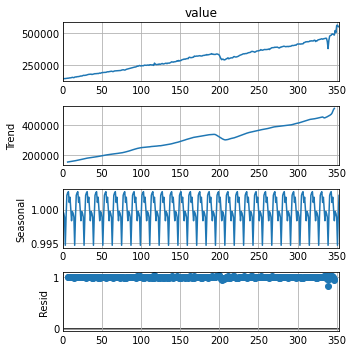

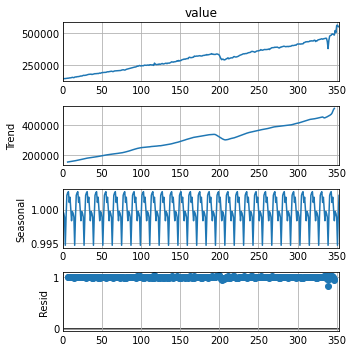

In [41]:
# Decomposing the Time Series
# These charts show trend and seasonality - the steady movement across the third chart shows
# seasonality visually, while the two charts above confirm a trend component in the data

decompose_result = seasonal_decompose(df['value'],model='multiplicative', period=12)
decompose_result.plot()

In [42]:
# Setting the frequency of the date time index as Monthly start as indicated by the data

df.set_index('Date',inplace=True)
df.index.freq = 'MS'

# Defining m (Time Period) and setting value of alpha
m = 12
alpha = 1/(2*m)

<AxesSubplot:title={'center':'Holt Winters Single Exponential Smoothing'}, xlabel='Date'>

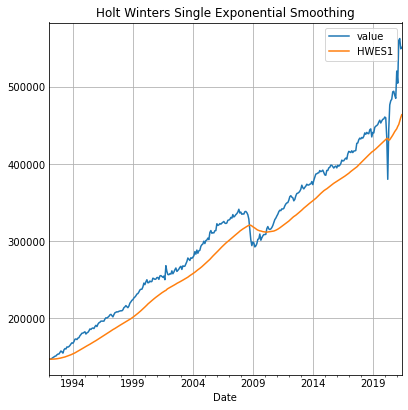

In [43]:
# Next, going through the HWES process more than once to best smooth the data before modeling
# We will see it's not an ideal fit because single HWES does not account for trend and seasonality in data
# appropriately

# Single HWES
df['HWES1'] = SimpleExpSmoothing(df['value']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues
df[['value','HWES1']].plot(title='Holt Winters Single Exponential Smoothing')

<AxesSubplot:title={'center':'Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend'}, xlabel='Date'>

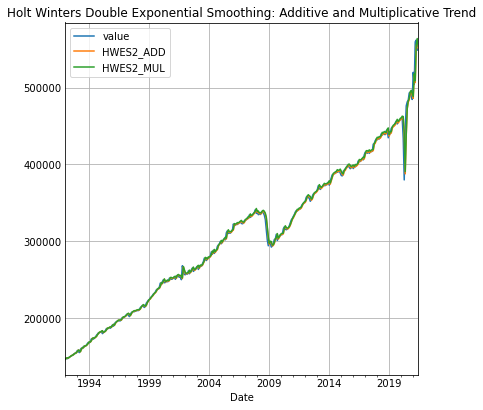

In [44]:
# Double HWES - Will account for seasonality
# Showing this with both additive and multiplicative trend

df['HWES2_ADD'] = ExponentialSmoothing(df['value'],trend='add').fit().fittedvalues
df['HWES2_MUL'] = ExponentialSmoothing(df['value'],trend='mul').fit().fittedvalues
df[['value','HWES2_ADD','HWES2_MUL']].plot(title='Holt Winters Double Exponential Smoothing: Additive and Multiplicative Trend')

<AxesSubplot:title={'center':'Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='Date'>

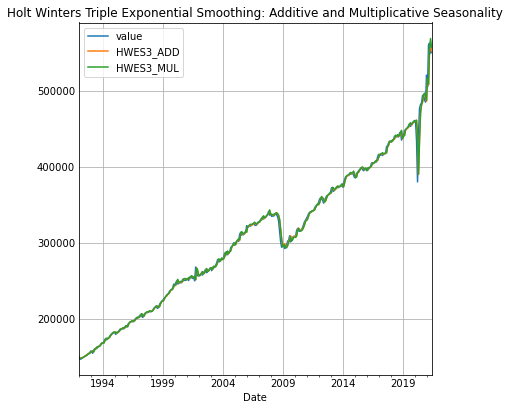

In [45]:
# Triple HWES - Seasonality and Trend both taken into account in smoothing process
# Again, showing additive and multiplicative, and both appear to perform essentially the same

df['HWES3_ADD'] = ExponentialSmoothing(df['value'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df['HWES3_MUL'] = ExponentialSmoothing(df['value'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df[['value','HWES3_ADD','HWES3_MUL']].plot(title='Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality')

In [46]:
# Forecasting w/ Holt-Winters Exponential Smoothing (Triple ES)
# Splitting into training and testing... the Test set is our last 12 months of data

df_test = df.tail(12)
df_train = df.head(len(df)-12)

Text(0.5, 1.0, 'Train, Test and Predicted Test with Holt Winters')

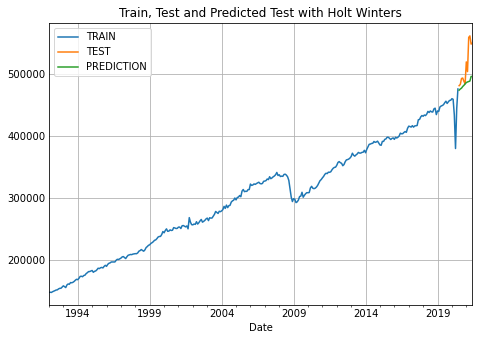

In [47]:
# Fitting and forecasting the model
# Here we can see the training vs testing 
# Having seen our full dataset, we know that even though this does show trend and seasonality
# taken into account in future predictions, it does NOT account for the type of increase seen
# in our actual data for 2021 

fitted_model = ExponentialSmoothing(df_train['value'], trend='mul', seasonal='mul', seasonal_periods=12).fit()
test_predictions = fitted_model.forecast(12)
df_train['value'].plot(legend=True, label='TRAIN')
df_test['value'].plot(legend=True, label='TEST', figsize=(6,4))
test_predictions.plot(legend=True, label='PREDICTION')

plt.title('Train, Test and Predicted Test with Holt Winters')

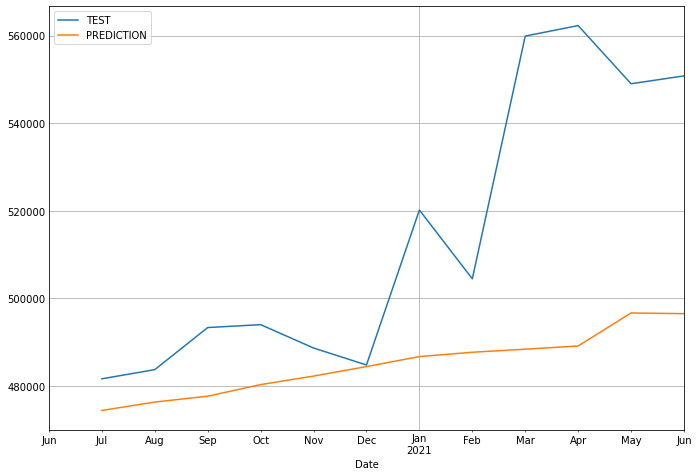

In [48]:
# Visualizing the test data vs. what is predicted for the last 12 months of data

df_test['value'].plot(legend=True,label='TEST',figsize=(9,6))
test_predictions.plot(legend=True,label='PREDICTION',xlim=['2020-06-01','2021-06-01']);

In [52]:
# A summary of training data

print(fitted_model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    value   No. Observations:                  342
Model:             ExponentialSmoothing   SSE                    12152526302.793
Optimized:                         True   AIC                           5978.009
Trend:                   Multiplicative   BIC                           6039.366
Seasonal:                Multiplicative   AICC                          5980.127
Seasonal Periods:                    12   Date:                 Fri, 11 Aug 2023
Box-Cox:                          False   Time:                         15:46:05
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8889286                alpha                 True
smoothing_trend          

In [53]:
# Predictions for the last 12 months using our model - 
# This looks great for the remainder of 2020, but going into 2021 it's not helpful
# When we look at our real data though, we see 2021 saw growth that far exceeds
# normal seasonal/trending growth

test_predictions

2020-07-01    474398.423468
2020-08-01    476315.277481
2020-09-01    477655.367568
2020-10-01    480300.945422
2020-11-01    482247.894855
2020-12-01    484413.359355
2021-01-01    486702.001879
2021-02-01    487686.931430
2021-03-01    488385.408698
2021-04-01    489114.335239
2021-05-01    496657.955488
2021-06-01    496500.938537
Freq: MS, dtype: float64